In [1]:
# Sample API
import flowx
import simulation
import numpy
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40

xmin, xmax = 0.0, 2.0*numpy.pi
ymin, ymax = 0.0, 2.0*numpy.pi

Re   = 1.0
dt   = 0.001
tmax = 2.

# Define cell-centered variable names
center_vars = ['pres', 'divp', 'divc','asol','eror']
face_vars   = ['velc', 'hvar','asol','eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

simulation.update_bc_val(gridx, gridy, 'velc', 0.0)

In [3]:
simulation.get_initial(gridc, gridx, gridy, 'velc', 'pres')

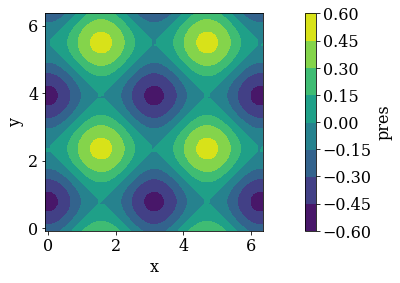

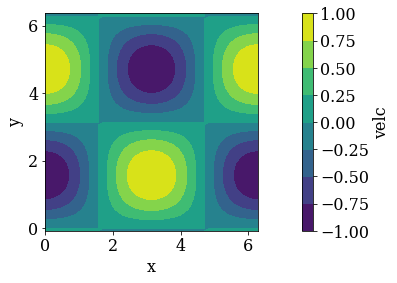

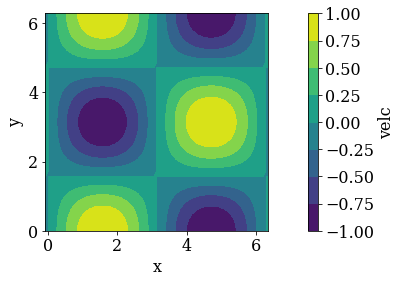

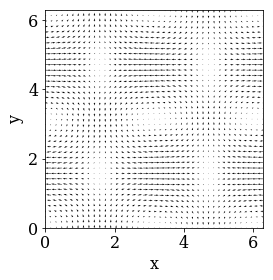

In [4]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridy, 'velc')
flowx.io.plot_vector(gridx, gridy, 'velc')

In [5]:
t  = 0.0
nt = 0

ins_stats = dict()

while t <= tmax:
    
    # Update the time-dependent boundary condition value
    simulation.update_bc_val(gridx, gridy, 'velc', t)
    
    # Calculate predicted velocity: u* = dt*H(u^n)
    flowx.ins.predictor(gridx, gridy, 'velc', 'hvar', Re, dt)
    
    # Calculate RHS for the pressure Poission solver div(u)/dt
    flowx.ins.divergence(gridc, gridx, gridy, 'velc', 'divp', ifac=dt)
    
    # Solve the pressure Poisson equation 
    ins_stats['ites'], ins_stats['res'] = flowx.poisson.solve_jacobi(gridc, 'pres', 'divp',
                                                                       maxiter=10000, tol=1e-9)
    
    # Calculate corrected velocity u^n+1 = u* - dt * grad(P) 
    flowx.ins.corrector(gridc, gridx, gridy, 'velc', 'pres', dt)
    
    # Calculate divergence of the corrected velocity to display stats
    flowx.ins.divergence(gridc, gridx, gridy, 'velc', 'divc')
    
    # Calculate stats
    ins_stats.update(flowx.ins.stats(gridc, gridx, gridy, 'velc', 'pres', 'divc'))
    
    # Display stats
    if nt % 10 == 0:
        flowx.io.display_stats(t, ins_stats)   
    
    t += dt
    nt += 1

------------ Time = 0.0 ---------------
Number of poisson iterations    : 7417
Final poisson residual : 9.99571729800983e-10
Max, Min, U   : 0.9969173337331281, -0.996917333733128
Max, Min, V   : 0.996917333733128, -0.9969173337331281
Max, Min, P   : 1.4734081003521733, -1.4879921080215859
Max, Min, DIV : 2.2339513572333658e-10, -2.233951773567e-10


------------ Time = 0.010000000000000002 ---------------
Number of poisson iterations    : 509
Final poisson residual : 9.92442445066887e-10
Max, Min, U   : 0.9771770479217199, -0.9771770479217198
Max, Min, V   : 0.9771770479217198, -0.9771770479217199
Max, Min, P   : 0.47262875909160745, -0.4741854063699062
Max, Min, DIV : 3.1079094853225797e-10, -3.4293154427267325e-10


------------ Time = 0.02000000000000001 ---------------
Number of poisson iterations    : 459
Final poisson residual : 9.886572099041928e-10
Max, Min, U   : 0.9578276459586815, -0.9578276459586814
Max, Min, V   : 0.9578276459586814, -0.9578276459586815
Max, Min, P   : 0.

------------ Time = 0.22000000000000017 ---------------
Number of poisson iterations    : 393
Final poisson residual : 9.86636617839831e-10
Max, Min, U   : 0.6420510717332313, -0.6420510717332312
Max, Min, V   : 0.6420510717332312, -0.6420510717332313
Max, Min, P   : 0.2041798723105469, -0.2047541736139848
Max, Min, DIV : 2.2482782302546411e-10, -4.083666998305757e-10


------------ Time = 0.23000000000000018 ---------------
Number of poisson iterations    : 390
Final poisson residual : 9.929021212927039e-10
Max, Min, U   : 0.6293376087080936, -0.6293376087080935
Max, Min, V   : 0.6293376087080935, -0.6293376087080936
Max, Min, P   : 0.19617974720802958, -0.19672616566763018
Max, Min, DIV : 2.2995583215390525e-10, -4.1140125854599585e-10


------------ Time = 0.24000000000000019 ---------------
Number of poisson iterations    : 387
Final poisson residual : 9.993728317613304e-10
Max, Min, U   : 0.6168758891177192, -0.6168758891177192
Max, Min, V   : 0.6168758891177192, -0.61687588911771

------------ Time = 0.44000000000000034 ---------------
Number of poisson iterations    : 344
Final poisson residual : 9.965166563968697e-10
Max, Min, U   : 0.41350427439166537, -0.4135042743916653
Max, Min, V   : 0.4135042743916653, -0.41350427439166537
Max, Min, P   : 0.08473578123421904, -0.08492398267130394
Max, Min, DIV : 2.774647733794211e-10, -3.907190829557927e-10


------------ Time = 0.45000000000000034 ---------------
Number of poisson iterations    : 342
Final poisson residual : 9.988757249635718e-10
Max, Min, U   : 0.4053163411653829, -0.40531634116538284
Max, Min, V   : 0.40531634116538284, -0.4053163411653829
Max, Min, P   : 0.08141501103476766, -0.08159354748851126
Max, Min, DIV : 2.797528875220223e-10, -3.8975338711652596e-10


------------ Time = 0.46000000000000035 ---------------
Number of poisson iterations    : 341
Final poisson residual : 9.802404379561207e-10
Max, Min, U   : 0.3972905398798565, -0.3972905398798565
Max, Min, V   : 0.3972905398798565, -0.397290539

------------ Time = 0.6600000000000005 ---------------
Number of poisson iterations    : 305
Final poisson residual : 9.96649470831321e-10
Max, Min, U   : 0.26631181298178935, -0.2663118129817893
Max, Min, V   : 0.2663118129817893, -0.26631181298178935
Max, Min, P   : 0.035164329032182695, -0.03521841106378474
Max, Min, DIV : 2.967749934690289e-10, -3.53244551014667e-10


------------ Time = 0.6700000000000005 ---------------
Number of poisson iterations    : 304
Final poisson residual : 9.804866909610608e-10
Max, Min, U   : 0.2610384857706667, -0.26103848577066663
Max, Min, V   : 0.26103848577066663, -0.2610384857706667
Max, Min, P   : 0.03378633313381617, -0.03383711809541692
Max, Min, DIV : 2.921958230928112e-10, -3.4660768309310863e-10


------------ Time = 0.6800000000000005 ---------------
Number of poisson iterations    : 302
Final poisson residual : 9.878655004122631e-10
Max, Min, U   : 0.25586957743441174, -0.2558695774344117
Max, Min, V   : 0.2558695774344117, -0.255869577434

------------ Time = 0.8800000000000007 ---------------
Number of poisson iterations    : 269
Final poisson residual : 9.855791322602624e-10
Max, Min, U   : 0.1715145069249544, -0.17151450692495437
Max, Min, V   : 0.17151450692495437, -0.1715145069249544
Max, Min, P   : 0.014594283425709884, -0.014607591971379988
Max, Min, DIV : 2.984345548462386e-10, -3.246734623773423e-10


------------ Time = 0.8900000000000007 ---------------
Number of poisson iterations    : 267
Final poisson residual : 9.94490685767713e-10
Max, Min, U   : 0.1681182921407026, -0.16811829214070256
Max, Min, V   : 0.16811829214070256, -0.1681182921407026
Max, Min, P   : 0.014022468181746304, -0.014035658856893736
Max, Min, DIV : 3.01338176633692e-10, -3.2665275042156883e-10


------------ Time = 0.9000000000000007 ---------------
Number of poisson iterations    : 266
Final poisson residual : 9.791442765436426e-10
Max, Min, U   : 0.16478932691491419, -0.16478932691491419
Max, Min, V   : 0.16478932691491419, -0.1647893

------------ Time = 1.0999999999999897 ---------------
Number of poisson iterations    : 233
Final poisson residual : 9.922872678806761e-10
Max, Min, U   : 0.11046158920378973, -0.11046158920378972
Max, Min, V   : 0.11046158920378972, -0.11046158920378973
Max, Min, P   : 0.006058209721842753, -0.006068425971110604
Max, Min, DIV : 3.029844569679696e-10, -3.130640955891287e-10


------------ Time = 1.1099999999999886 ---------------
Number of poisson iterations    : 232
Final poisson residual : 9.772353337968782e-10
Max, Min, U   : 0.10827430318891074, -0.10827430318891074
Max, Min, V   : 0.10827430318891074, -0.10827430318891074
Max, Min, P   : 0.005820904945001446, -0.005830970433120263
Max, Min, DIV : 2.9844032800596665e-10, -3.079741589789159e-10


------------ Time = 1.1199999999999875 ---------------
Number of poisson iterations    : 230
Final poisson residual : 9.86577249034335e-10
Max, Min, U   : 0.10613032833898393, -0.10613032833898392
Max, Min, V   : 0.10613032833898392, -0.10

------------ Time = 1.3199999999999654 ---------------
Number of poisson iterations    : 198
Final poisson residual : 9.821710392886522e-10
Max, Min, U   : 0.07114128657796835, -0.07114128657796835
Max, Min, V   : 0.07114128657796835, -0.07114128657796835
Max, Min, P   : 0.002515495412949606, -0.0025225716055912706
Max, Min, DIV : 3.007974425095483e-10, -3.0294120174651634e-10


------------ Time = 1.3299999999999643 ---------------
Number of poisson iterations    : 196
Final poisson residual : 9.91919942893956e-10
Max, Min, U   : 0.06973259472106041, -0.0697325947210604
Max, Min, V   : 0.0697325947210604, -0.06973259472106041
Max, Min, P   : 0.0024169966250922833, -0.0024239438016847264
Max, Min, DIV : 3.038085061302098e-10, -3.0571553443067487e-10


------------ Time = 1.3399999999999632 ---------------
Number of poisson iterations    : 195
Final poisson residual : 9.771700243737263e-10
Max, Min, U   : 0.06835179683182122, -0.0683517968318212
Max, Min, V   : 0.0683517968318212, -0.06

------------ Time = 1.5399999999999412 ---------------
Number of poisson iterations    : 163
Final poisson residual : 9.80050571304938e-10
Max, Min, U   : 0.045827533760730704, -0.04582753376072587
Max, Min, V   : 0.04582753376073048, -0.0458275337607261
Max, Min, P   : 0.0010448715379883099, -0.001049470562943518
Max, Min, DIV : 3.0047910687391877e-10, -3.001390363999677e-10


------------ Time = 1.54999999999994 ---------------
Number of poisson iterations    : 161
Final poisson residual : 9.90386973965454e-10
Max, Min, U   : 0.0449207105703533, -0.044920710570348577
Max, Min, V   : 0.04492071057035309, -0.04492071057034879
Max, Min, P   : 0.0010039770328502554, -0.0010084816340530196
Max, Min, DIV : 3.0365579495317263e-10, -3.0332148511641455e-10


------------ Time = 1.559999999999939 ---------------
Number of poisson iterations    : 160
Final poisson residual : 9.759639765131255e-10
Max, Min, U   : 0.044031835183631005, -0.0440318351836264
Max, Min, V   : 0.044031835183630796, -0.

------------ Time = 1.759999999999917 ---------------
Number of poisson iterations    : 128
Final poisson residual : 9.94476066460884e-10
Max, Min, U   : 0.029524231510701226, -0.02952423151069832
Max, Min, V   : 0.029524231510701084, -0.029524231510698436
Max, Min, P   : 0.0004342192370216762, -0.00043707591159749165
Max, Min, DIV : 3.049386784748087e-10, -3.047592780078875e-10


------------ Time = 1.7699999999999159 ---------------
Number of poisson iterations    : 127
Final poisson residual : 9.797090443799674e-10
Max, Min, U   : 0.028940074205175276, -0.028940074205172434
Max, Min, V   : 0.028940074205175158, -0.02894007420517257
Max, Min, P   : 0.0004172345421050214, -0.00042002742341889034
Max, Min, DIV : 3.004050515287293e-10, -3.0023438680397245e-10


------------ Time = 1.7799999999999148 ---------------
Number of poisson iterations    : 125
Final poisson residual : 9.915687669177085e-10
Max, Min, U   : 0.02836747780165845, -0.028367477801655678
Max, Min, V   : 0.028367477801

------------ Time = 1.9899999999998916 ---------------
Number of poisson iterations    : 94
Final poisson residual : 9.784689449212197e-10
Max, Min, U   : 0.018645520889679943, -0.01864552088967824
Max, Min, V   : 0.018645520889566523, -0.018645520889564973
Max, Min, P   : 0.00017349423427274723, -0.00017516012711001993
Max, Min, DIV : 3.0071315576529756e-10, -2.9985128044266764e-10


------------ Time = 1.9999999999998905 ---------------
Number of poisson iterations    : 92
Final poisson residual : 9.94279962565657e-10
Max, Min, U   : 0.018276653847132857, -0.018276653847131195
Max, Min, V   : 0.018276653847386398, -0.01827665384738488
Max, Min, P   : 0.0001667126225782585, -0.00016833835343023026
Max, Min, DIV : 3.067233064757424e-10, -3.0523834355271687e-10




In [6]:
simulation.get_analytical(gridc, gridx, gridy, 'asol', t)

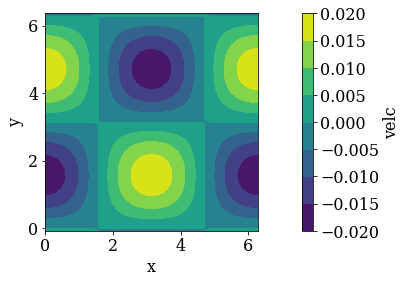

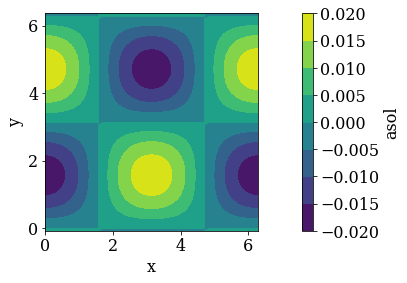

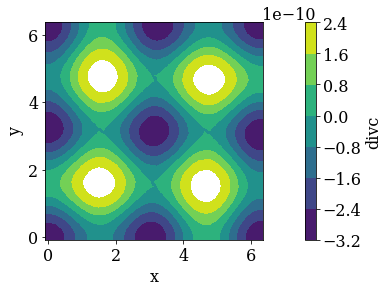

In [7]:
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridx, 'asol')
flowx.io.plot_contour(gridc, 'divc')

In [8]:
gridx.get_error('eror','velc','asol')
gridy.get_error('eror','velc','asol')

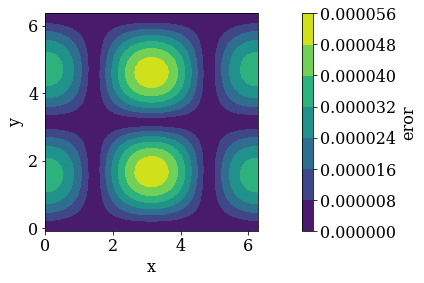

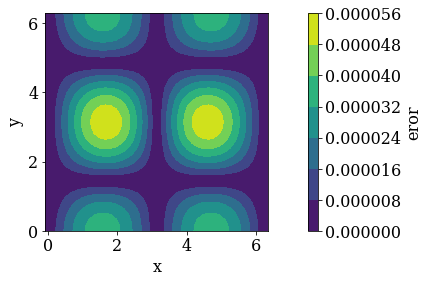

In [9]:
flowx.io.plot_contour(gridx, 'eror')
flowx.io.plot_contour(gridy, 'eror')